In [1]:
import matplotlib.image
import matplotlib.pyplot
import math
import numpy as np
# matplotlib.pyplot.ioff()

In [2]:
num_beliefs = 16
DATA_TRUNC = 1

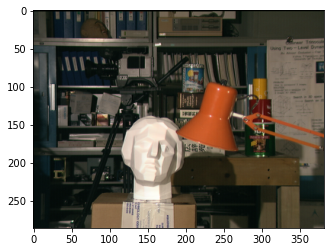

In [3]:
input_left = matplotlib.image.imread('tsukuba-imL.png')
matplotlib.pyplot.imshow(input_left)

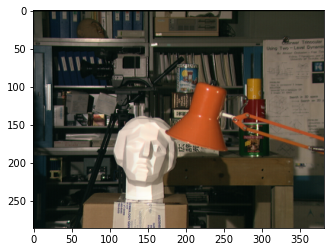

In [4]:
input_right = matplotlib.image.imread('tsukuba-imR.png')
matplotlib.pyplot.imshow(input_right)

In [5]:
height = input_left.shape[0]
width = input_left.shape[1]

In [6]:
base_beliefs = np.ones(shape=(height, width, num_beliefs), dtype=np.float32)

In [7]:


for b in range(num_beliefs):
    left_slice = input_left[:,num_beliefs-1:]
    right_slice = input_right[:, num_beliefs-1-b:width-b]
    norm = np.linalg.norm(left_slice-right_slice, axis=2)
    norm[norm > DATA_TRUNC] = DATA_TRUNC
#     np.negative(norm, out=norm)
#     np.exp(norm, out=norm)
    base_beliefs[:, num_beliefs-1:,b] = norm
    
print(norm)

[[0.00392157 0.00554594 0.00392157 ... 0.01176471 0.01176471 0.00960584]
 [0.00392157 0.         0.00392157 ... 0.01109187 0.03636713 0.01467317]
 [0.08856148 0.01176471 0.18843943 ... 0.02147931 0.04522573 0.046068  ]
 ...
 [0.0087689  0.01300637 0.01176471 ... 0.00679236 0.03862297 0.02716942]
 [0.00392157 0.01616904 0.00960584 ... 0.01663781 0.03941128 0.0533391 ]
 [0.01300637 0.02630669 0.00679236 ... 0.01467317 0.0328102  0.02934633]]


In [8]:
# base_beliefs[:,:] *= (1 / np.sum(base_beliefs[:,:],axis=2)[:,:, np.newaxis])

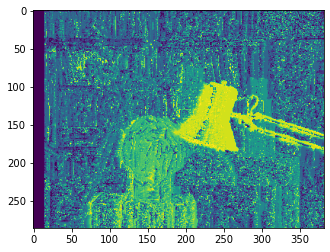

In [9]:
most_likely = np.argmin(base_beliefs[:,:], axis=2)
matplotlib.pyplot.imshow(most_likely)

In [10]:
def smoothfunc(d):
    d = abs(d)
    return d**2
#     return math.exp(-(d**2))
def howsmooth(a,b,threshold=3):
    if smoothfunc(a-b) < threshold:
        return  smoothfunc(a-b)
    else:
        return threshold
    
# def howsmooth(a,b,threshold=2):
#     return smoothfunc(a-b)


In [11]:
smoothness = np.ndarray(shape=(num_beliefs, num_beliefs), dtype=np.float32)
for a in range(num_beliefs):
    for b in range(num_beliefs):
        smoothness[a][b] = howsmooth(a,b)

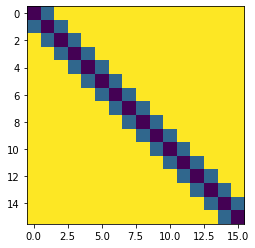

In [12]:
matplotlib.pyplot.imshow(smoothness)

In [13]:
RIGHT=0
UP = 1
LEFT = 2
DOWN = 3
BASE = 4
DIRECTIONS = {"right": RIGHT, "up":UP, "left":LEFT, "down": DOWN, "base": BASE}

In [14]:
data = np.zeros( shape = (height, width, 5, num_beliefs),
                dtype = np.float32)
# data /= num_beliefs

In [15]:
working = np.zeros( shape = (height, width, 4, num_beliefs, num_beliefs),
                   dtype = np.float32)
# working /= num_beliefs

In [16]:
beliefsum = np.ndarray( shape = (height, width, num_beliefs),
                         dtype = np.float32)
belief = np.ndarray( shape = (height, width),
                     dtype = int )

In [17]:
sumstorage = np.ndarray( shape = (height, width),
                         dtype = np.float32)

In [18]:
data[:,:,DIRECTIONS["base"],:] = base_beliefs * (1/np.sum(base_beliefs, axis=2, keepdims=True))

In [19]:
smoothness /= np.sum(smoothness,axis=1, keepdims=True)

In [20]:
howmany = 40

In [21]:
def pass_messages(direction):
    if direction == RIGHT:
        working_slice = working[:,:-1, RIGHT]
        from_slice = data[:,:-1]
        to_slice = data[:, 1:]
        from_dir = LEFT
        to_dir = RIGHT
        storage = sumstorage[:, 1:]
    elif direction == UP:
        working_slice = working[1:, :, UP]
        from_slice = data[1:,:]
        to_slice = data[:-1, :]
        from_dir = DOWN
        to_dir = UP
        storage = sumstorage[:-1, :]
    elif direction == LEFT:
        working_slice = working[:, 1:, LEFT]
        from_slice = data[:,1:]
        to_slice = data[:, :-1]
        from_dir = RIGHT
        to_dir = LEFT
        storage = sumstorage[:,:-1]
    elif direction == DOWN:
        working_slice = working[:-1, :, DOWN]
        from_slice = data[:-1, :]
        to_slice = data[1:, :]
        from_dir = UP
        to_dir = DOWN
        storage = sumstorage[1:, :]
    else:
        raise Exception("invalid direction index: %s" % direction)
        
    working_slice[:] = smoothness 
 
    working_slice[:] += from_slice[:,:, BASE,np.newaxis, :]
    for d in (RIGHT,UP, LEFT, DOWN):
        if d == to_dir: 
            continue
        working_slice[:] += from_slice[:,:,d,np.newaxis,:]
#     np.sum(working_slice, axis=3, out=to_slice[:,:,from_dir])
    to_slice[:,:,from_dir] = np.min(working_slice, axis=3)
    print(data[100,100,:,1])
    np.mean(to_slice[:,:,from_dir], axis=2, out=storage)
#     np.reciprocal(storage, out=storage)
    to_slice[:,:,from_dir] -= storage[:,:,np.newaxis]
        

def calc_belief():
    beliefsum = np.sum(data, axis=2)  
#     data.sum(axis=2, out=beliefsum)
    beliefsum.argmin(axis=2, out=belief)
    return belief
    

=======ITERATION:  0
[0.         0.         0.         0.05355855 0.01459987]
[ 0.02995189  0.          0.         -0.00137896  0.01459987]
[ 0.01196443  0.01705315  0.         -0.00137896  0.01459987]
[ 0.01196443  0.01109614 -0.01717408 -0.00137896  0.01459987]


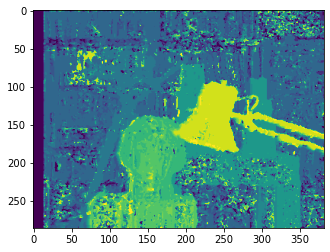

<Figure size 432x288 with 0 Axes>

=======ITERATION:  1
[ 0.01196443  0.01109614  0.01245291 -0.07756668  0.01459987]
[-0.10253778  0.01109614  0.01245291  0.01109614  0.01459987]
[ 0.01109615 -0.0912251   0.01245291  0.01109614  0.01459987]
[ 0.01109615  0.01109614 -0.10570972  0.01109614  0.01459987]


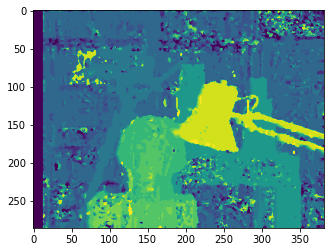

<Figure size 432x288 with 0 Axes>

=======ITERATION:  2
[ 0.01109615  0.01109614  0.01109614 -0.10788926  0.01459987]
[-0.10953019  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109613 -0.10282465  0.01109614  0.01109614  0.01459987]
[ 0.01109613  0.01109614 -0.10432535  0.01109614  0.01459987]


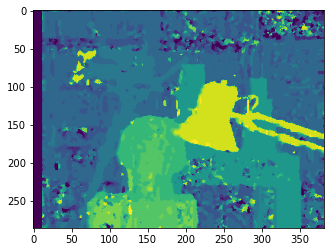

<Figure size 432x288 with 0 Axes>

=======ITERATION:  3
[ 0.01109613  0.01109614  0.01109614 -0.10788925  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.10483982  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.10606523  0.01109614  0.01459987]


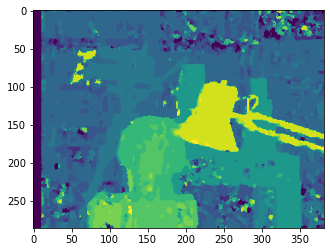

<Figure size 432x288 with 0 Axes>

=======ITERATION:  4
[ 0.01109614  0.01109614  0.01109614 -0.10788926  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.10572252  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.10668287  0.01109614  0.01459987]


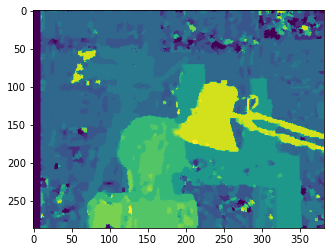

<Figure size 432x288 with 0 Axes>

=======ITERATION:  5
[ 0.01109614  0.01109614  0.01109613 -0.10788924  0.01459987]
[-0.10953017  0.01109614  0.01109613  0.01109614  0.01459987]
[ 0.01109614 -0.10495175  0.01109613  0.01109614  0.01459987]
[ 0.01109614  0.01109613 -0.10606523  0.01109614  0.01459987]


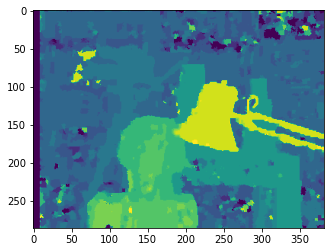

<Figure size 432x288 with 0 Axes>

=======ITERATION:  6
[ 0.01109614  0.01109613  0.01109614 -0.10788926  0.01459987]
[-0.10953017  0.01109613  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.10495176  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.10606524  0.01109614  0.01459987]


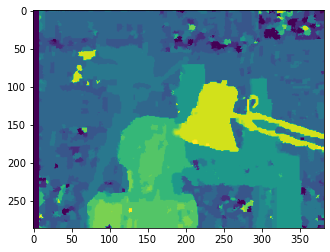

<Figure size 432x288 with 0 Axes>

=======ITERATION:  7
[ 0.01109614  0.01109614  0.01109614 -0.10788925  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.10077652  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109615 -0.10441992  0.01109614  0.01459987]


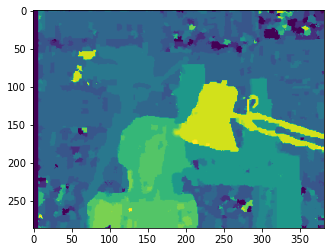

<Figure size 432x288 with 0 Axes>

=======ITERATION:  8
[ 0.01109614  0.01109615  0.01109614 -0.10788926  0.01459987]
[-0.10953017  0.01109615  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.08041435  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.10030061  0.01109614  0.01459987]


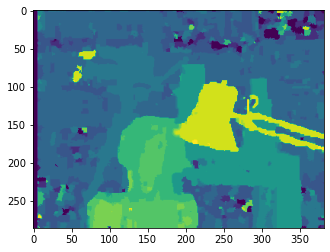

<Figure size 432x288 with 0 Axes>

=======ITERATION:  9
[ 0.01109614  0.01109614  0.01109615 -0.10788924  0.01459987]
[-0.10953017  0.01109614  0.01109615  0.01109614  0.01459987]
[ 0.01109614 -0.07923008  0.01109615  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.09193949  0.01109614  0.01459987]


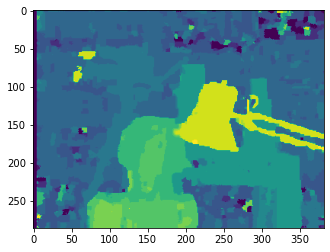

<Figure size 432x288 with 0 Axes>

=======ITERATION:  10
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953018  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870544  0.01109614  0.01459987]


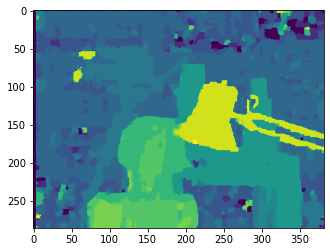

<Figure size 432x288 with 0 Axes>

=======ITERATION:  11
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109613  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870545  0.01109613  0.01459987]


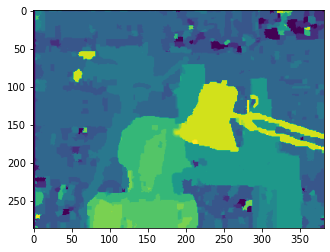

<Figure size 432x288 with 0 Axes>

=======ITERATION:  12
[ 0.01109614  0.01109614  0.01109614 -0.10788923  0.01459987]
[-0.10953014  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870544  0.01109614  0.01459987]


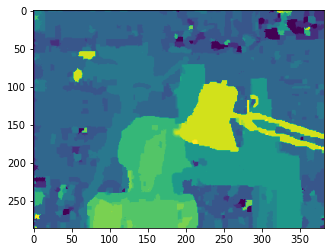

<Figure size 432x288 with 0 Axes>

=======ITERATION:  13
[ 0.01109614  0.01109614  0.01109615 -0.10788926  0.01459987]
[-0.10953017  0.01109614  0.01109615  0.01109614  0.01459987]
[ 0.01109614 -0.07876807  0.01109615  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870544  0.01109614  0.01459987]


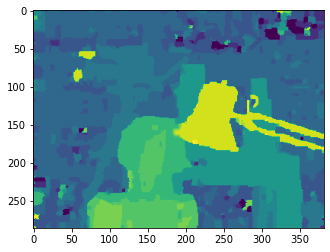

<Figure size 432x288 with 0 Axes>

=======ITERATION:  14
[ 0.01109614  0.01109614  0.01109614 -0.10788922  0.01459987]
[-0.10953015  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.0787681   0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870545  0.01109614  0.01459987]


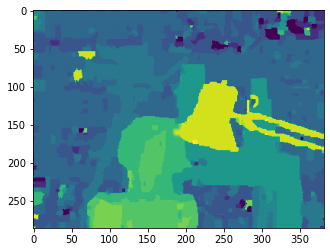

<Figure size 432x288 with 0 Axes>

=======ITERATION:  15
[ 0.01109614  0.01109614  0.01109614 -0.10788925  0.01459987]
[-0.10953018  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876807  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870549  0.01109614  0.01459987]


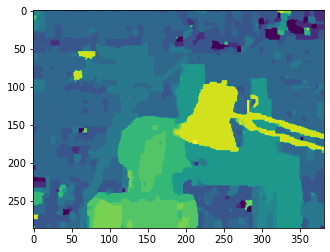

<Figure size 432x288 with 0 Axes>

=======ITERATION:  16
[ 0.01109614  0.01109614  0.01109614 -0.10788925  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876807  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870547  0.01109614  0.01459987]


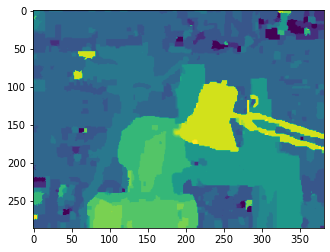

<Figure size 432x288 with 0 Axes>

=======ITERATION:  17
[ 0.01109614  0.01109614  0.01109615 -0.10788926  0.01459987]
[-0.10953017  0.01109614  0.01109615  0.01109614  0.01459987]
[ 0.01109614 -0.07876807  0.01109615  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870548  0.01109614  0.01459987]


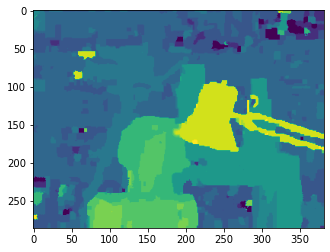

<Figure size 432x288 with 0 Axes>

=======ITERATION:  18
[ 0.01109614  0.01109614  0.01109614 -0.10788923  0.01459987]
[-0.10953016  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109613 -0.0787681   0.01109614  0.01109614  0.01459987]
[ 0.01109613  0.01109614 -0.08870547  0.01109614  0.01459987]


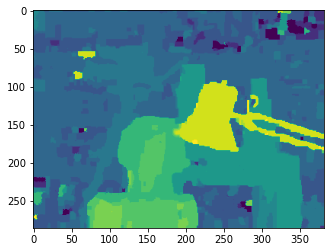

<Figure size 432x288 with 0 Axes>

=======ITERATION:  19
[ 0.01109613  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953018  0.01109614  0.01109614  0.01109613  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870547  0.01109613  0.01459987]


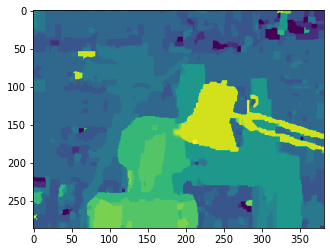

<Figure size 432x288 with 0 Axes>

=======ITERATION:  20
[ 0.01109614  0.01109614  0.01109614 -0.10788926  0.01459987]
[-0.10953018  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109615 -0.08870549  0.01109614  0.01459987]


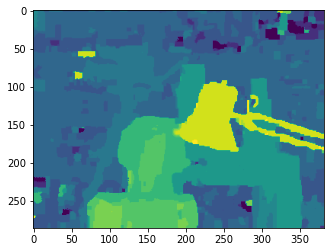

<Figure size 432x288 with 0 Axes>

=======ITERATION:  21
[ 0.01109614  0.01109615  0.01109614 -0.10788922  0.01459987]
[-0.10953018  0.01109615  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870544  0.01109614  0.01459987]


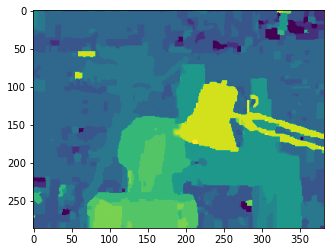

<Figure size 432x288 with 0 Axes>

=======ITERATION:  22
[ 0.01109614  0.01109614  0.01109615 -0.10788925  0.01459987]
[-0.10953017  0.01109614  0.01109615  0.01109614  0.01459987]
[ 0.01109614 -0.0787681   0.01109615  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870547  0.01109614  0.01459987]


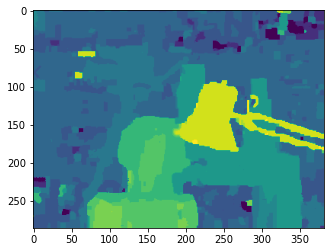

<Figure size 432x288 with 0 Axes>

=======ITERATION:  23
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953015  0.01109614  0.01109614  0.01109613  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870552  0.01109613  0.01459987]


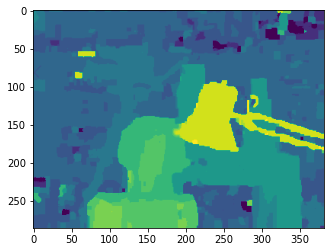

<Figure size 432x288 with 0 Axes>

=======ITERATION:  24
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953015  0.01109614  0.01109614  0.01109613  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870546  0.01109613  0.01459987]


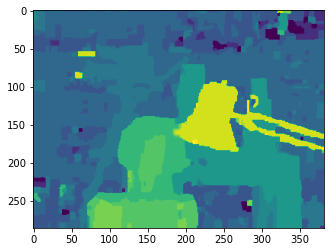

<Figure size 432x288 with 0 Axes>

=======ITERATION:  25
[ 0.01109614  0.01109614  0.01109614 -0.10788923  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870547  0.01109614  0.01459987]


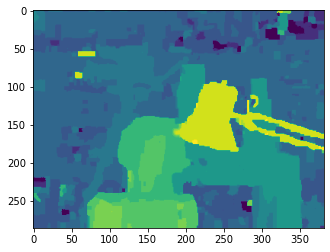

<Figure size 432x288 with 0 Axes>

=======ITERATION:  26
[ 0.01109614  0.01109614  0.01109614 -0.10788923  0.01459987]
[-0.10953015  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109615 -0.08870548  0.01109614  0.01459987]


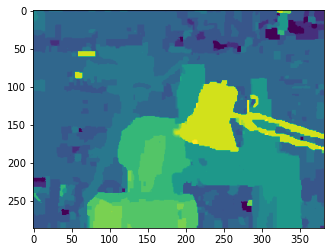

<Figure size 432x288 with 0 Axes>

=======ITERATION:  27
[ 0.01109614  0.01109615  0.01109614 -0.10788925  0.01459987]
[-0.10953017  0.01109615  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109615 -0.08870549  0.01109614  0.01459987]


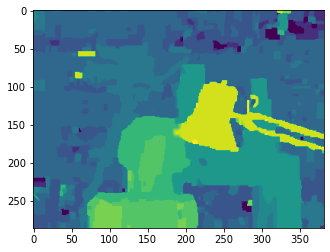

<Figure size 432x288 with 0 Axes>

=======ITERATION:  28
[ 0.01109614  0.01109615  0.01109614 -0.10788924  0.01459987]
[-0.10953017  0.01109615  0.01109614  0.01109613  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870548  0.01109613  0.01459987]


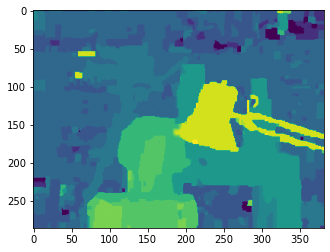

<Figure size 432x288 with 0 Axes>

=======ITERATION:  29
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.0787681   0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870549  0.01109614  0.01459987]


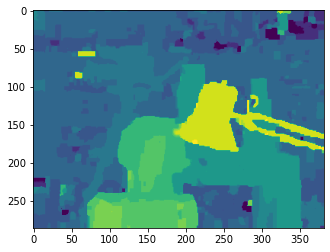

<Figure size 432x288 with 0 Axes>

=======ITERATION:  30
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953015  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109615 -0.08870549  0.01109614  0.01459987]


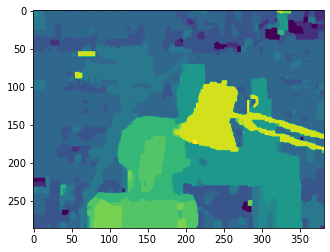

<Figure size 432x288 with 0 Axes>

=======ITERATION:  31
[ 0.01109614  0.01109615  0.01109614 -0.10788924  0.01459987]
[-0.10953015  0.01109615  0.01109614  0.01109613  0.01459987]
[ 0.01109614 -0.0787681   0.01109614  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870544  0.01109613  0.01459987]


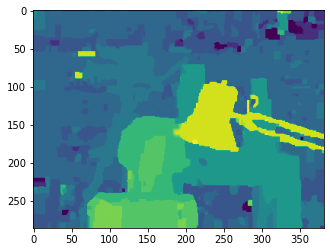

<Figure size 432x288 with 0 Axes>

=======ITERATION:  32
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953015  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.0787681   0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870547  0.01109614  0.01459987]


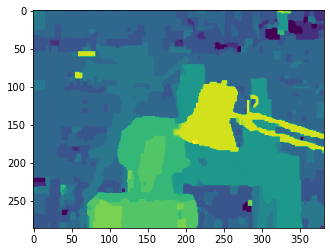

<Figure size 432x288 with 0 Axes>

=======ITERATION:  33
[ 0.01109614  0.01109614  0.01109614 -0.10788926  0.01459987]
[-0.10953015  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870549  0.01109614  0.01459987]


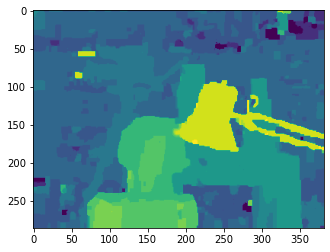

<Figure size 432x288 with 0 Axes>

=======ITERATION:  34
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876808  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870544  0.01109614  0.01459987]


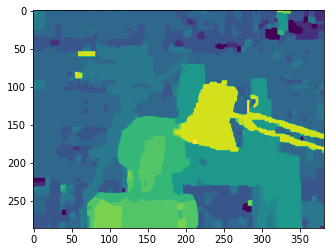

<Figure size 432x288 with 0 Axes>

=======ITERATION:  35
[ 0.01109614  0.01109614  0.01109615 -0.10788924  0.01459987]
[-0.10953016  0.01109614  0.01109615  0.01109613  0.01459987]
[ 0.01109613 -0.07876807  0.01109615  0.01109613  0.01459987]
[ 0.01109613  0.01109614 -0.08870547  0.01109613  0.01459987]


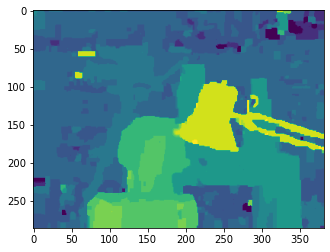

<Figure size 432x288 with 0 Axes>

=======ITERATION:  36
[ 0.01109613  0.01109614  0.01109615 -0.10788924  0.01459987]
[-0.10953017  0.01109614  0.01109615  0.01109613  0.01459987]
[ 0.01109614 -0.07876808  0.01109615  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870547  0.01109613  0.01459987]


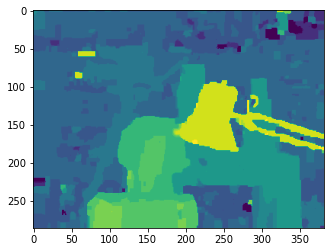

<Figure size 432x288 with 0 Axes>

=======ITERATION:  37
[ 0.01109614  0.01109614  0.01109614 -0.10788925  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109614  0.01109614 -0.08870548  0.01109614  0.01459987]


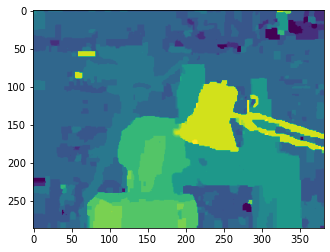

<Figure size 432x288 with 0 Axes>

=======ITERATION:  38
[ 0.01109614  0.01109614  0.01109614 -0.10788924  0.01459987]
[-0.10953017  0.01109614  0.01109614  0.01109613  0.01459987]
[ 0.01109614 -0.07876809  0.01109614  0.01109613  0.01459987]
[ 0.01109614  0.01109614 -0.08870542  0.01109613  0.01459987]


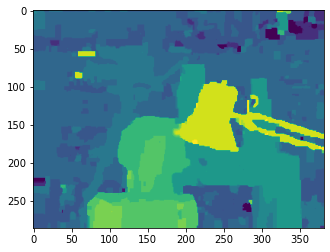

<Figure size 432x288 with 0 Axes>

=======ITERATION:  39
[ 0.01109614  0.01109614  0.01109614 -0.10788923  0.01459987]
[-0.10953016  0.01109614  0.01109614  0.01109614  0.01459987]
[ 0.01109613 -0.07876809  0.01109614  0.01109614  0.01459987]
[ 0.01109613  0.01109614 -0.08870544  0.01109614  0.01459987]


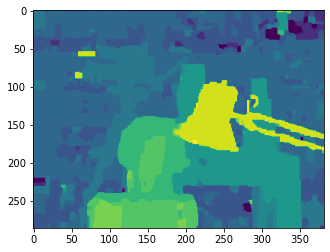

<Figure size 432x288 with 0 Axes>

In [22]:
for i in range(howmany):
    print("=======ITERATION: ", i)
    pass_messages(UP)
    pass_messages(LEFT)
    pass_messages(DOWN)
    pass_messages(RIGHT)
    matplotlib.pyplot.imshow(calc_belief())
    matplotlib.pyplot.figure()
    matplotlib.pyplot.show()

In [23]:
data[100,100,:,:]

array([[ 0.00769285,  0.01109613,  0.01109613,  0.01109613,  0.01109613,
        -0.03768436, -0.06207459, -0.03768436,  0.01109613,  0.01109613,
         0.01109613,  0.01109613,  0.01109613,  0.01109613,  0.01109613,
         0.00769285],
       [ 0.00769286,  0.01109614,  0.01109614,  0.01109614,  0.01109614,
        -0.03768434, -0.06207458, -0.03768434,  0.01109614,  0.01109614,
         0.01109614,  0.01109614,  0.01109614,  0.01109614,  0.01109614,
         0.00769286],
       [ 0.00769287,  0.01109615,  0.01109615,  0.01109615,  0.01109615,
        -0.03768434, -0.06207459, -0.03768434,  0.01109615,  0.01109615,
         0.01109615,  0.01109615,  0.01109615,  0.01109615,  0.01109615,
         0.00769287],
       [ 0.00769285,  0.01109614,  0.01109614,  0.01109614,  0.01109614,
        -0.03768435, -0.06207459, -0.03768435,  0.01109614,  0.01109614,
         0.01109614,  0.01109614,  0.01109614,  0.01109614,  0.01109614,
         0.00769285],
       [ 0.00572165,  0.01459987,  0

TypeError: Invalid shape () for image data

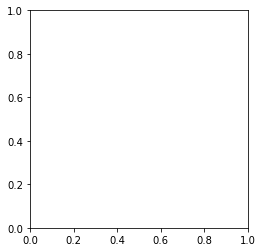

In [24]:
matplotlib.pyplot.imshow(a)

In [ ]:
matplotlib.pyplot.show()